              Open         High          Low        Close    Adj Close  \
count  5758.000000  5758.000000  5758.000000  5758.000000  5758.000000   
mean    340.458153   344.156408   336.344390   340.417580   340.417580   
std     523.365374   528.138556   517.726971   523.140207   523.140207   
min       1.406250     1.447917     1.312500     1.395833     1.395833   
25%      37.460001    38.334999    36.812499    37.562500    37.562500   
50%      81.965000    83.520000    79.875000    81.599998    81.599998   
75%     335.267494   337.537491   331.727501   334.290001   334.290001   
max    2173.070068  2185.949951  2161.120117  2170.219971  2170.219971   

             Volume  
count  5.758000e+03  
mean   7.556094e+06  
std    7.325904e+06  
min    4.872000e+05  
25%    3.685525e+06  
50%    5.692450e+06  
75%    8.594350e+06  
max    1.043292e+08  
              Open         High          Low        Close    Adj Close  \
count  7589.000000  7589.000000  7589.000000  7589.000000  75

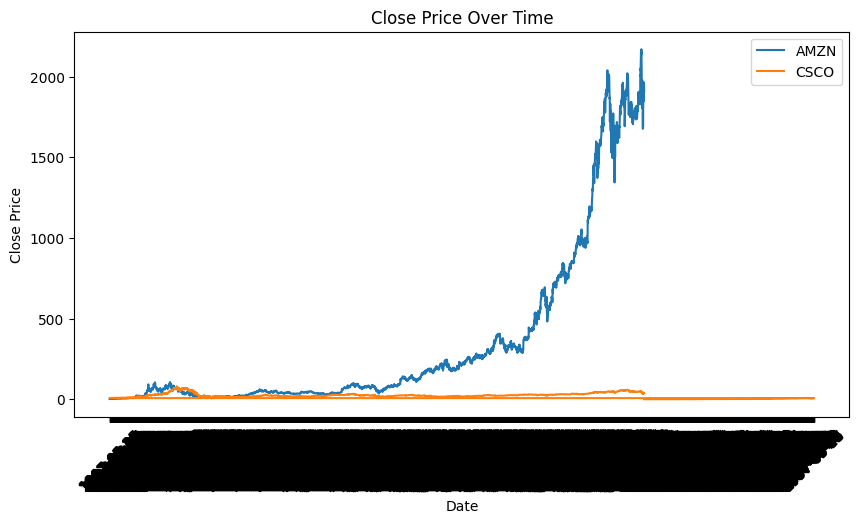

In [16]:
#EXPLORATORY DATA ANALYSIS
# import pandas as pd
import matplotlib.pyplot as plt

file_path_amzn = 'C:/Users/annau/Downloads/Dataset B-2602205540/Dataset B/AMZN.csv'
file_path_csco = 'C:/Users/annau/Downloads/Dataset B-2602205540/Dataset B/CSCO.csv'

amzn_data = pd.read_csv(file_path_amzn)
csco_data = pd.read_csv(file_path_csco)

print(amzn_data.describe())
print(csco_data.describe())


plt.figure(figsize=(10, 5))
plt.plot(amzn_data['Date'], amzn_data['Close'], label='AMZN')
plt.plot(csco_data['Date'], csco_data['Close'], label='CSCO')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()



PREPROCESSING & DATA SPLITTING

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def create_time_series(data, window_size, horizon):
    X = []
    y = []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size + horizon - 1])
    return np.array(X), np.array(y)

scaler_amzn = MinMaxScaler()
scaler_csco = MinMaxScaler()

close_prices_amzn = scaler_amzn.fit_transform(amzn_data['Close'].values.reshape(-1, 1))
close_prices_csco = scaler_csco.fit_transform(csco_data['Close'].values.reshape(-1, 1))

window_size = 5
horizon = 1

X_amzn, y_amzn = create_time_series(close_prices_amzn, window_size, horizon)
X_csco, y_csco = create_time_series(close_prices_csco, window_size, horizon)

def split_data(X, y, train_size=0.8, val_size=0.1):
    train_size = int(train_size * len(X))
    val_size = int(val_size * len(X))
    test_size = len(X) - train_size - val_size

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_amzn, X_val_amzn, X_test_amzn, y_train_amzn, y_val_amzn, y_test_amzn = split_data(X_amzn, y_amzn)
X_train_csco, X_val_csco, X_test_csco, y_train_csco, y_val_csco, y_test_csco = split_data(X_csco, y_csco)

print(f'Train set size (AMZN): {len(X_train_amzn)}')
print(f'Validation set size (AMZN): {len(X_val_amzn)}')
print(f'Test set size (AMZN): {len(X_test_amzn)}')

print(f'Train set size (CSCO): {len(X_train_csco)}')
print(f'Validation set size (CSCO): {len(X_val_csco)}')
print(f'Test set size (CSCO): {len(X_test_csco)}')




Train set size (AMZN): 4602
Validation set size (AMZN): 575
Test set size (AMZN): 576
Train set size (CSCO): 6067
Validation set size (CSCO): 758
Test set size (CSCO): 759


LSTM MODEL

Epoch 1/50
144/144 [==============================] - 6s 12ms/step - loss: 7.8487e-04 - val_loss: 0.0164
Epoch 2/50
144/144 [==============================] - 1s 9ms/step - loss: 1.3111e-04 - val_loss: 0.0084
Epoch 3/50
144/144 [==============================] - 1s 9ms/step - loss: 1.1116e-04 - val_loss: 0.0057
Epoch 4/50
144/144 [==============================] - 1s 9ms/step - loss: 9.4962e-05 - val_loss: 0.0025
Epoch 5/50
144/144 [==============================] - 1s 9ms/step - loss: 8.7655e-05 - val_loss: 0.0019
Epoch 6/50
144/144 [==============================] - 1s 9ms/step - loss: 8.5172e-05 - val_loss: 6.6542e-04
Epoch 7/50
144/144 [==============================] - 1s 10ms/step - loss: 7.5735e-05 - val_loss: 6.4300e-04
Epoch 8/50
144/144 [==============================] - 1s 9ms/step - loss: 7.3228e-05 - val_loss: 1.7356e-04
Epoch 9/50
144/144 [==============================] - 1s 9ms/step - loss: 7.0042e-05 - val_loss: 2.4943e-04
Epoch 10/50
144/144 [=========================

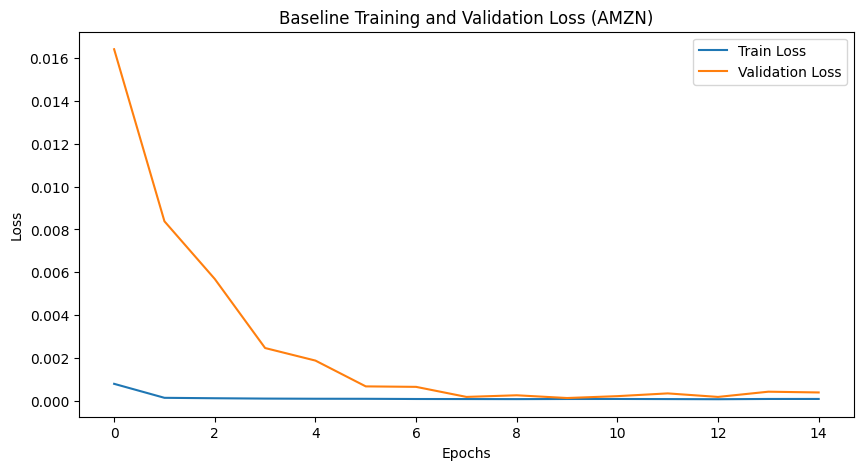

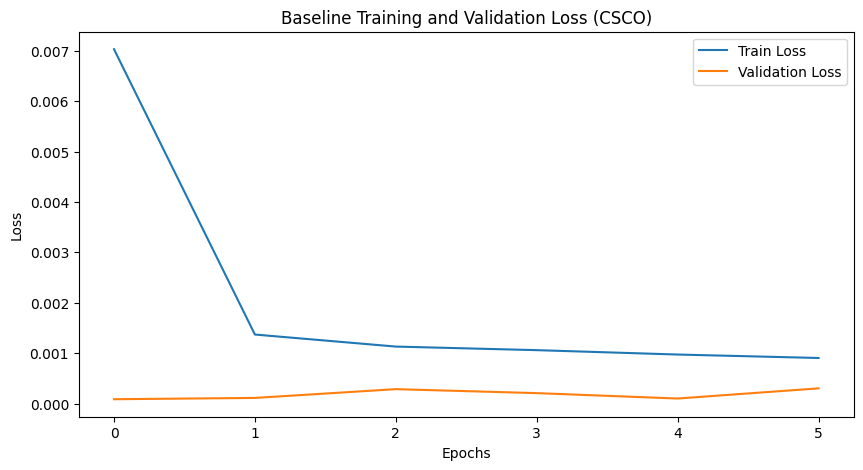

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def train_baseline_model(X_train, y_train, X_val, y_val, window_size):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(window_size, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping])
    
    return model, history

baseline_model_amzn, baseline_history_amzn = train_baseline_model(X_train_amzn, y_train_amzn, X_val_amzn, y_val_amzn, window_size)
baseline_model_csco, baseline_history_csco = train_baseline_model(X_train_csco, y_train_csco, X_val_csco, y_val_csco, window_size)

def plot_history(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(baseline_history_amzn, 'Baseline Training and Validation Loss (AMZN)')
plot_history(baseline_history_csco, 'Baseline Training and Validation Loss (CSCO)')



ARCHITECTURE MODIFICATION

c:\Users\annau\Downloads\combio\environments\computational_biology\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/50
144/144 [==============================] - 6s 45ms/step - loss: 2.5237e-04 - val_loss: 0.0023
Epoch 2/50
144/144 [==============================] - 4s 28ms/step - loss: 2.3131e-04 - val_loss: 0.0027
Epoch 3/50
144/144 [==============================] - 4s 29ms/step - loss: 2.8003e-04 - val_loss: 9.7531e-04
Epoch 4/50
144/144 [==============================] - 6s 39ms/step - loss: 2.7209e-04 - val_loss: 0.0029
Epoch 5/50
144/144 [==============================] - 6s 42ms/step - loss: 2.7801e-04 - val_loss: 5.7062e-04
Epoch 6/50
144/144 [==============================] - 6s 43ms/step - loss: 2.5470e-04 - val_loss: 4.4698e-04
Epoch 7/50
144/144 [==============================] - 6s 44ms/step - loss: 2.6541e-04 - val_loss: 0.0012
Epoch 8/50
144/144 [==============================] - 5s 35ms/step - loss: 2.6416e-04 - val_loss: 3.3023e-04
Epoch 9/50
144/144 [==============================] - 5s 34ms/step - loss: 2.8857e-0

c:\Users\annau\Downloads\combio\environments\computational_biology\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Epoch 1/50
190/190 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 3.6075e-04
Epoch 2/50
190/190 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 5.3206e-04
Epoch 3/50
190/190 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 4/50
190/190 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 3.7399e-04
Epoch 5/50
190/190 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/50
190/190 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 3.5461e-04
Epoch 7/50
190/190 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 3.6923e-04
Epoch 8/50
190/190 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 8.2137e-04
Epoch 9/50
190/190 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 4.9076e-04
Epoch 10/50
190/190 [==============================] - 1s 5ms/step - los

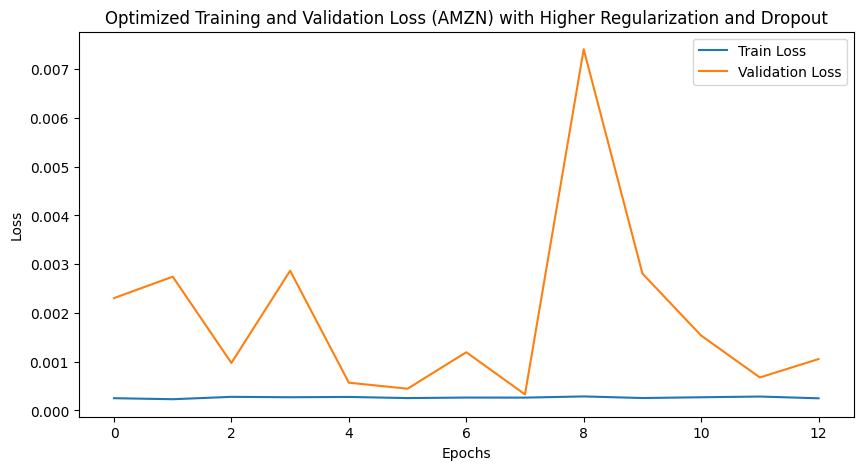

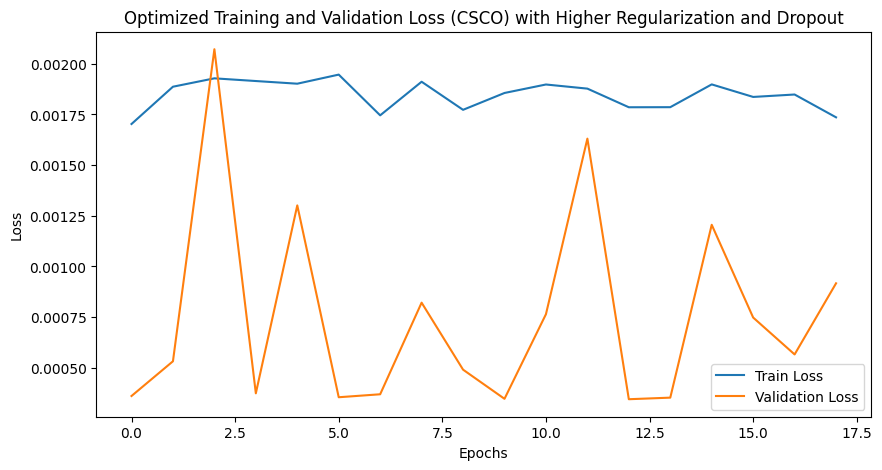

In [21]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def create_model(units=50, dropout_rate=0.5, learning_rate=0.001, l2_lambda=0.1):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(window_size, 1), kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, kernel_regularizer=l2(l2_lambda)))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def hyperparameter_tuning(X_train, y_train, X_val, y_val, window_size):
    model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

    param_distributions = {
        'units': [50, 100],
        'dropout_rate': [0.4, 0.5],
        'learning_rate': [0.001, 0.0001],
        'l2_lambda': [0.01, 0.1]
    }

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=8, cv=3, verbose=1, n_jobs=1)
    random_search_result = random_search.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train)

    best_model = random_search_result.best_estimator_.model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = best_model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=50, validation_data=(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), y_val), callbacks=[early_stopping])

    return best_model, history, random_search_result.best_params_

best_model_amzn, best_history_amzn, best_params_amzn = hyperparameter_tuning(X_train_amzn, y_train_amzn, X_val_amzn, y_val_amzn, window_size)
best_model_csco, best_history_csco, best_params_csco = hyperparameter_tuning(X_train_csco, y_train_csco, X_val_csco, y_val_csco, window_size)

plot_history(best_history_amzn, 'Optimized Training and Validation Loss (AMZN) with Higher Regularization and Dropout')
plot_history(best_history_csco, 'Optimized Training and Validation Loss (CSCO) with Higher Regularization and Dropout')


EVALUATION

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi untuk evaluasi model

def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return rmse, mae, mape

# Evaluasi model terbaik
baseline_rmse_amzn, baseline_mae_amzn, baseline_mape_amzn = evaluate_model(baseline_model_amzn, X_test_amzn, y_test_amzn, scaler_amzn)
best_rmse_amzn, best_mae_amzn, best_mape_amzn = evaluate_model(best_model_amzn, X_test_amzn, y_test_amzn, scaler_amzn)

baseline_rmse_csco, baseline_mae_csco, baseline_mape_csco = evaluate_model(baseline_model_csco, X_test_csco, y_test_csco, scaler_csco)
best_rmse_csco, best_mae_csco, best_mape_csco = evaluate_model(best_model_csco, X_test_csco, y_test_csco, scaler_csco)

print("Baseline Model Evaluation (AMZN)")
print(f"RMSE: {baseline_rmse_amzn}")
print(f"MAE: {baseline_mae_amzn}")
print(f"MAPE: {baseline_mape_amzn}")

print("\nOptimized Model Evaluation (AMZN)")
print(f"RMSE: {best_rmse_amzn}")
print(f"MAE: {best_mae_amzn}")
print(f"MAPE: {best_mape_amzn}")

print("\nBaseline Model Evaluation (CSCO)")
print(f"RMSE: {baseline_rmse_csco}")
print(f"MAE: {baseline_mae_csco}")
print(f"MAPE: {baseline_mape_csco}")

print("\nOptimized Model Evaluation (CSCO)")
print(f"RMSE: {best_rmse_csco}")
print(f"MAE: {best_mae_csco}")
print(f"MAPE: {best_mape_csco}")


24/24 [==============================] - 0s 3ms/step
Baseline Model Evaluation (AMZN)
RMSE: 0.2072038462931054
MAE: 0.19014059213363146
MAPE: 23.113525772131613

Optimized Model Evaluation (AMZN)
RMSE: 0.1026494605890132
MAE: 0.09660792660554568
MAPE: 11.873317136569733

Baseline Model Evaluation (CSCO)
RMSE: 0.02394234208449086
MAE: 0.02054924188215263
MAPE: 3.660138585917308

Optimized Model Evaluation (CSCO)
RMSE: 0.01843028334563581
MAE: 0.013077358639255921
MAPE: 2.3801828396735525


ANALISIS
Dari hasil evaluasi model, terlihat bahwa model optimized menunjukkan peningkatan performa dibandingkan model baseline baik untuk data AMZN maupun CSCO. Pada model AMZN, RMSE pada model optimized menurun dari 0.2072 menjadi 0.1026, MAE dari 0.1901 menjadi 0.0967, dan MAPE dari 23.11% menjadi 11.87%. Sementara itu, untuk data CSCO, RMSE pada model optimized menurun dari 0.0239 menjadi 0.0184, MAE dari 0.0205 menjadi 0.0138, dan MAPE dari 3.66% menjadi 2.38%. 

Namun, dari grafik training dan validation loss, terlihat bahwa validation loss masih menunjukkan fluktuasi yang signifikan, terutama pada model optimized. Ini menandakan bahwa terjadi masalah overfitting meskipun metrik evaluasi menunjukkan peningkatan. Penyebab fluktuasi ini bisa jadi karena  pengaturan hyperparameter yang masih perlu disempurnakan lebih lanjut. Secara keseluruhan, meskipun model optimized menunjukkan performa yang lebih baik dibandingkan baseline, masih diperlukan peningkatan lebih lanjut untuk menangani overfitting dan meningkatkan stabilitas model.